In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numba import jit
from numba import cuda
import numba
import time
import multiprocessing as mp
import matplotlib.font_manager as font_manager
import sys
from tqdm import tqdm
import scipy.io as scio

In [18]:
@jit(nopython = True)
def Degree_generate_homo(node_num, lamb, k_min, k_max, seeds = 10):
    # np.random.seed(seeds)
    degree = np.ones(node_num)
    for i in range(int(node_num)):
        while(True):
            random_degree = np.random.poisson(lamb)
            if((random_degree >= k_min) and (random_degree <= k_max)):
                break           
        degree[i] = int(random_degree)
    return degree

@jit(nopython = True)
def network_generate(K, degree, seeds =10):
    # np.random.seed(seeds)
    n = degree.size
#     p_max = 2*sigma/K
    m = int(np.max(degree))
    index_matrix = np.zeros((n,m))
#     p = np.zeros((n,m))
    degree_clone = np.copy(degree)
    fail_report, fail_report_degree = [], []     ### to double check how many edges do the left nodes have
    for i in range (int(n)):
        temp = []   ### to record the neighbors of nodes
        flag_temp = 0
        while(degree[i]!=0):
            flag = 0
            while(True):
                ram_connect = np.random.randint(degree.size) # 
                flag = flag + 1
#                 print(i, flag, ram_connect, degree[ram_connect])
                if (flag > (1000*degree.size)):
#                     print(i, flag_temp, 'fail')
                    flag = 0
                    fail_report.append(i)
                    break
                if ((ram_connect!= i) and (degree[ram_connect]!= 0) and ((ram_connect not in temp))):
                    break
            if(flag != 0):
                temp.append(ram_connect) 
                flag_temp = flag_temp + 1
                index_matrix[i][int(degree_clone[i] - degree[i])] = ram_connect
                index_matrix[ram_connect][int(degree_clone[ram_connect]-degree[ram_connect])] = i
#                 p_value = np.random.random()*p_max # [0, 1] * pmax
#                 p_value = 1e-1
#                 p[i][int(degree_clone[i]-degree[i])] = p_value
#                 p[ram_connect][int(degree_clone[ram_connect]-degree[ram_connect])] = p_value
                degree[i] = degree[i] - 1
                degree[ram_connect] = degree[ram_connect] - 1
            else:
                break
    for j in range(len(fail_report)):
        fail_report_degree.append(degree[int(fail_report[j])])
#     print(fail_report_degree)
    return index_matrix


In [19]:
###   external stimulus   ###
@jit(nopython = True)
def external(t_min, t_max, t, r):
    if t_min < t < t_max:
        return (1 - np.exp(-r))
    else:
        return 0
###   internal(neural) stimulus   ###
@jit(nopython = True)  
def internal(p, index_matrix, index, state_matrix, degree):
    # index here is the neuron at resting state 
    probability = 0
    for i in range (int(degree[index])) :
        if (state_matrix[int(index_matrix[index][i])] == 1): # find the excitable neibour neuron
            probability = 1 - (1 - p[index][i]) * (1 - probability)
    return probability

@jit(nopython = True)
def state_update(r, t, t_min, t_max, p, index_matrix, index,\
                 state_matrix, degree, state_number, temp, random_arr):
    probability = 1 - ((1-external(t_min, t_max, t, r))* \
                        (1 - internal(p, index_matrix, index, state_matrix, degree)))
    if random_arr[index] < probability:
        temp[index] = 1
            
###   determine the activity   ###
@jit(nopython = True)
def rho_determine(state_matrix):
    active = [i for i, v in enumerate(state_matrix) if v==1]
    return len(active)/state_matrix.size

###   determine the average activity   ###
@jit(nopython = True)
def F0_determine(rho, T_min = 0, T_max = 1000):
    return rho[T_min:T_max].sum()/rho[T_min:T_max].size

In [20]:
@jit(nopython = True)
def KC_model(degree, index_matrix, p, t_min, stimulas_t, stimulas_S, MC_times, state_number):
    
    ###   Initialization   ###
    rho = np.zeros(MC_times)
    N = degree.size
    state_matrix = np.random.randint(0, state_number, N)
    temp = np.copy(state_matrix)
    
    ###   Monte Carlo   ###
    for t in range(MC_times):
        
        ###   Update refractory state   ###
        temp[np.where(state_matrix == 0)[0]] -= 1 
        temp[np.where(state_matrix<(state_number-1))] += 1 
        temp[np.where(state_matrix==(state_number-1))] = 0 
        
        ###   Locate the excitable neurons   ###
        zeros = np.where(state_matrix == 0)[0]
        random_arr = np.random.random(N)
        for i in range((zeros.size)):
            state_update(stimulas_S, t, t_min, stimulas_t, p, index_matrix, \
                         zeros[i], state_matrix, degree, state_number, temp, random_arr)
        state_matrix = np.copy(temp)
        rho[t] = rho_determine(state_matrix)
    return rho

In [5]:
# N = 10**5
# K = 10
# k_min = 2
# k_max = N - 1
# # sigma = 1
# p_value = 1e-1

# degree = Degree_generate_homo(N, K, k_min, k_max)
# # print(np.max(degree))
# # print(np.random.randint(degree.size))
# # plt.plot(degree)
# degree_clone = degree.copy()
# network_connection = network_generate(K, degree_clone, 10)

# ## propagation matrix 
# network_p = np.copy(network_connection)
# network_p[np.where(network_p != 0.0)] = p_value

# ## degree 
# network_index = np.copy(network_connection)
# network_index[np.where(network_index)] = 1
# network_degree = np.sum(network_index,axis = 1)

In [6]:
# print(degree.sum())
# plt.hist(degree,25)
# plt.title('N vs degree')
# print(network_degree.sum())
# network_degree = np.sum(network_index,axis = 1)
# plt.figure()
# plt.hist(network_degree,25)
# plt.title('N vs degree')

In [7]:
# # p_clone = np.copy(p)
# # sigma = sigma_check(p_clone,degree)
# sigma_i = network_degree*0.1
# print(sigma_i)
# print(sigma_i.sum()/N)
# plt.hist(sigma_i,20)
# plt.title('$\sigma_i$ the branching ration vs N($\sigma_i$) corresponding node')
# plt.text(2.0, 17500, f'$<\sigma_i>$ = {sigma_i.sum()/N}', horizontalalignment='center',
#      verticalalignment='center')

In [21]:
import sys
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

def autocorr_range(ts, lag_range):
    ac_array = []
    for lag in lag_range:
        ac_array.append(pd.Series.autocorr(pd.Series(ts), lag))
    return ac_array

def decay_func(x, a, tau, b):
    return a * np.exp(-(x/tau)) + b

def decay(data, lag_max):
    xvar = list(range(lag_max))
    
    popt, pcov = curve_fit(decay_func, xvar, autocorr_range(pd.Series(data), xvar))
    return popt # Return the decay constant

## functions for removing node and connections for aging simulation 

In [22]:
      
def convert_removing_to_inital(network_connection_removing):
    n,m = network_connection_removing.shape
    # print(n,m)
    index_matrix = np.zeros((n,m))
    for i in range(n):
        row = network_connection_removing[i,:]
        row_ind = row[np.where(row)]
        index_matrix[i,:len(row_ind)] = row_ind
#         print(index_matrix[i,:])
    del_col = []
    for j in range(m):
        col = index_matrix[:,j]
        if not np.any(col):
#             print(j)
            del_col.append(j)
    return np.delete(index_matrix,del_col,1)

def progressive_remove_connections(network_connection1, p1, num_removing_connections):
    # p_value, the propagation rate 
    # the wanted sigma
#     np.random.seed(seeds)  
    N = network_connection1.shape[0]
    network_index1 = np.copy(network_connection1)
    network_index1[np.where(network_index1)] = 1
    
    xys = np.where(network_index1)
    # print(xys)
    xy = [i for i in zip(xys[0],xys[1])] #finding the existing connections
#     print(xy[:5])
    # the number of removing connections
    # num_removing_connections = int(sigma_difference/p_value*N)
#     print(num_removing_connections)
    # the connections will be removed 
    removing_connections = np.random.choice(len(xy), int(num_removing_connections), replace=False)
    # removing
    for i in removing_connections:
        x, y = xy[i]
        network_connection1[x,y] = 0
        
    network_connection2 = convert_removing_to_inital(network_connection1)
    
    network_index2 = np.copy(network_connection2)
    network_index2[np.where(network_index2)] = 1
    network_degree2 = np.sum(network_index2,axis = 1)  
    
    network_p2 = np.copy(network_connection2)
    network_p2[np.where(network_p2 != 0.0)] = p1    
    
    return network_connection2,network_p2,network_degree2
  
def progressive_remove_connections_todegree(network_connection1, p1, k1):
    # p_value, the propagation rate 
    # the wanted sigma
#     np.random.seed(seeds)  
    N = network_connection1.shape[0]
    network_index1 = np.copy(network_connection1)
    network_index1[np.where(network_index)] = 1
    
    korg = round(degree1.sum()/N,2)
    # print('korg is %f' %korg)
    
    xys = np.where(network_index1)
    # print(xys)
    xy = [i for i in zip(xys[0],xys[1])] #finding the existing connections
#     print(xy[:5])
    # the number of removing connections
    num_removing_connections1 = int((korg-k)*N)
    # print(len(xy),num_removing_connections)
    # the connections will be removed 
    removing_connections = np.random.choice(len(xy), num_removing_connections1, replace=False)
    # removing
    for i in removing_connections:
        x, y = xy[i]
        network_connection1[x,y] = 0

    network_connection2 = convert_removing_to_inital(network_connection1)
    
    network_index2 = np.copy(network_connection2)
    network_index2[np.where(network_index2)] = 1
    network_degree2 = np.sum(network_index2,axis = 1) 
    
    network_p2 = np.copy(network_connection2)
    network_p2[np.where(network_p2 != 0.0)] = p1  
    
    return network_connection2,network_p2,network_degree2    


In [23]:
# @jit(nopython = True)
def remove_node_connections_todegree(network_connection, K, avgd = 9 ):
    network_connection_clone = np.copy(network_connection)
    new_mean_degree = K
    
    while new_mean_degree > avgd:
        network_connection = remove_node_connections(network_connection_clone)
        new_degree = new_network_degree(network_connection)
        new_mean_degree = new_degree.mean()
    print(new_mean_degree)
    return  network_connection

# @jit(nopython = True)
def remove_ini_node_and_connections(network_connection1,p_value, ratio = 0.001, seeds = 10): 
    '''
        remove initial nodes and their assicated connections
        ratio should less than 0.005, in order to not affect the sigma
    '''
    
    # np.random.seed(seeds)
    N = network_connection1.shape[0]
    num_of_removed_node = int(ratio*N)
    remove_list = np.random.choice(N, size = num_of_removed_node, replace = False)
    # removing the node
    new_network_connection = np.delete(network_connection1,remove_list,axis = 0) 

    
    # removing the node assicated connections
    for i in remove_list: # removing the node connections
      new_network_connection[np.where(new_network_connection == i)] = 0
        # node_connections_removing = np.where(new_network_connection == i)
        # if node_connections_removing[0].size!=0:
        #     for i,j in list(zip(node_connections_removing[0], node_connections_removing [1])):
        #         new_network_connection[i,j] = 0
        #         new_p[i,j] = 0
        
    new_network_connection1 = convert_removing_to_inital(new_network_connection),
    network_p = np.copy(new_network_connection1)
    network_p[np.where(network_p != 0.0)] = p_value
    ## degree 
    network_index = np.copy(new_network_connection1)
    network_index[np.where(network_index)] = 1
    network_degree = np.sum(network_index,axis = 1)
    return new_network_connection1,network_p,network_degree

# @jit(nopython = True)
def remove_connections_to_sigma(network_connection, network_p, degree, sigma, p_value = 0.1,  seeds = 10):
    # p_value, the propagation rate 
    # the wanted sigma
    np.random.seed(seeds)
    ini_sigma = round(np.sum(degree)/N)*p_value
    if sigma>ini_sigma:
        raise NameError('the traget sigma should less than initial sigma')
        
    network_index = np.copy(network_connection)
    network_index[np.where(network_index)] = 1
    xys = np.where(network_index)
    # print(xys)
    xy = [i for i in zip(xys[0],xys[1])] #finding the existing connections
#     print(xy[:5])
    # the number of removing connections
    num_removing_connections = int((ini_sigma-sigma)/p_value*N)
#     print(num_removing_connections)
    # the connections will be removed 
    removing_connections = np.random.choice(len(xy), num_removing_connections, replace=False)
    # removing
    for i in removing_connections:
        x, y = xy[i]
        network_index[x,y] = 0
        network_connection[x,y] = 0
        network_p[x,y] = 0
    new_degree = np.sum(network_index,axis = 1)
    return network_connection,network_p,new_degree


In [24]:
# generate network with various k and various p
def aging_network2(network_connection1, network_degree1, network_p1, p_vlaue = 0.1,ratio = 0.0005, sigma_step = 0.01, times = 1000):
    
    network_connection_clone = np.copy(network_connection1)
    network_degree_clone = np.copy(network_degree1)
    network_p_clone = np.copy(network_p1)
    N = network_connection_clone.shape[0]
    
    # comment out followings to removing initial nodes
    network_connection2, network_p2, network_degree2 = remove_ini_node_and_connections(network_connection1, ratio)
    network_connection_clone = np.copy(network_connection2)
    network_degree_clone = np.copy(network_degree2)
    # print(degree_clone)
    network_p_clone = np.copy(network_p2) 
    N = 10**5 
    # p = 0.1
    # K = [20]
    for k in K:
        times = 1000
        r = 1/N
        n = 10
        t_test = np.arange(times)

        rho = []
        sigmas = []
        taus = []
        F0 = []

        network_connection, network_degree = init_network(k)

        network_p = np.copy(network_connection)
        network_p[np.where(network_p != 0.0)] = p

        print('********************************')
        print('Generated network with average degree :%d'%k)
        print('********************************')
        # max_sigma = round(k*p,2)
        # traget_sigma = np.arange(0.6,max_sigma,0.05)
        for sigma in  traget_sigma:
          kp = sigma/p
          print('the sigma is %f'%kp)

        #   network_degree_clone = np.copy(network_degree)
        #   print(degree_clone)
        #   network_connection_clone = np.copy(network_connection)
        #   network_p_clone = np.copy(network_p)

          network_connection3, network_p3, network_degree3 = \
                  progressive_remove_connections_todegree(network_connection_clone, \
                                                    network_p_clone, network_degree_clone, kp )
          print(network_connection)
          print(network_connection3)
          break


In [25]:
def init_network(K, N = 10**5, p_value = 1e-1):    
    # K = 10
    k_min = 2
    k_max = N - 1
    # sigma = 1
    # p_value = 1e-1

    degree = Degree_generate_homo(N, K, k_min, k_max)
    # print(np.max(degree))
    # print(np.random.randint(degree.size))
    # plt.plot(degree)
    degree_clone = degree.copy()
    network_connection = network_generate(K, degree_clone)
    # ## propagation matrix 
    network_p = np.copy(network_connection)
    network_p[np.where(network_p != 0.0)] = p_value
    ## degree 
    network_index = np.copy(network_connection)
    network_index[np.where(network_index)] = 1
    network_degree = np.sum(network_index,axis = 1)
    
    return network_connection, network_degree, network_p

# progressively remove network degree k with fixed p_vlaue
def aging_network(network_connection1, network_degree1, network_p1, p_vlaue = 0.1, ratio = 0.0005, sigma_step = 0.01, times = 1000):
     
    network_connection_clone = np.copy(network_connection1)
    network_degree_clone = np.copy(network_degree1)
    network_p_clone = np.copy(network_p1)
    N = network_connection_clone.shape[0]
    
    # # comment out followings to removing initial nodes
    # network_connection2, network_p2, network_degree2 = remove_ini_node_and_connections(network_connection1, ratio)
    # network_connection_clone = np.copy(network_connection2)
    # network_degree_clone = np.copy(network_degree2)
    # # print(degree_clone)
    # network_p_clone = np.copy(network_p2)
    

    max_sigma = round(network_degree_clone.sum()/N*p_vlaue,2)
    print('==> ==> inital sigma: %f'%max_sigma)
      
    num_removing_connections_each_setp = sigma_step*N/p_vlaue
    traget_sigma = np.arange(0.6, max_sigma, sigma_step)
    print(traget_sigma)
    
    
    times1 = times
    r = 1/N
    n = 10
    t_test1 = np.arange(times1)
    p_vlaue1 = p_vlaue
    print('==> ==> ==> sigma with aging: %f'%round(network_degree_clone.sum()/N*p_vlaue1,2))
    
    rho = []
    sigmas = []
    taus = []
    F0 = []
    # degrees = []
    
    # degrees.append(network_degree_clone)
    
    rho_test = KC_model(network_degree_clone, network_connection_clone, network_p_clone, 0, times1, r, times1, n)
    rho.append(rho_test)
    tau = decay(rho_test[50:],25)
    taus.append(tau[1])
    sigmas.append(round(network_degree_clone.sum()/N*p_vlaue1,2))
    F0.append(F0_determine(rho_test))

    j = 0
    while j<len(traget_sigma):
        
        
        network_connection3, network_p3, network_degree3 = \
            progressive_remove_connections(network_connection_clone, p_vlaue1,\
                                           num_removing_connections_each_setp)

        network_degree_clone = np.copy(network_degree3)
    #     print(degree_clone)
        network_connection_clone = np.copy(network_connection3)
        network_p_clone = np.copy(network_p3)

        # degrees.append(network_degree)
        rho_test = KC_model(network_degree_clone, network_connection_clone, network_p_clone, 0, times, r, times, n)
        rho.append(rho_test)
        tau = decay(rho_test[50:],25)
        taus.append(tau[1])
        sigmas.append(round(network_degree_clone.sum()/N*p_vlaue1,2))
        print('==> ==> ==> sigma with aging: %.2f'%round(network_degree_clone.sum()/N*p_vlaue1,2))
        # print(round(network_degree_clone.mean(),2)*p)
        F0.append(F0_determine(rho_test))

        j = j +1
    return rho,sigmas,taus,F0

## The mian function

In [27]:
k = 20
trails = 50
run = 0 
times = 5050
while run < trails:
    network_connection,  network_degree, network_p = init_network(k)
    print('********************************')
    print('Run %d Generated network with avaerage degree k = %d '%(run+1,k))
    print('********************************')
    # np.save(f'Aging_network/network_connection_{k}.mat', network_connection)
    # np.save(f'Aging_network/network_p_{k}.mat', network_p)
    
    rho,sigmas,taus,F0 = aging_network(network_connection,network_degree,network_p,\
                                      p_vlaue = 0.1, sigma_step = 0.01, times = times )
    # scio.savemat(f'Aging_network/Timeseries_{k}.mat',{'sigmas':sigmas,'rho':rho,'intf':taus,'F0':F0})
    scio.savemat(f'Aging_network/K{k}Timeseries_{run+1}.mat',{'sigmas':sigmas,'rho':rho,'intf':taus,'F0':F0})
    run = run + 1

## ploting intrinsic timescale vs simga for multiple trials

[2.   1.99 1.98 1.97 1.96 1.95 1.94 1.93 1.92 1.91 1.9  1.89 1.88 1.87
 1.86 1.85 1.84 1.83 1.82 1.81 1.8  1.79 1.78 1.77 1.76 1.75 1.74 1.73
 1.72 1.71 1.7  1.69 1.68 1.67 1.66 1.65 1.64 1.63 1.62 1.61 1.6  1.59
 1.58 1.57 1.56 1.55 1.54 1.53 1.52 1.51 1.5  1.49 1.48 1.47 1.46 1.45
 1.44 1.43 1.42 1.41 1.4  1.39 1.38 1.37 1.36 1.35 1.34 1.33 1.32 1.31
 1.3  1.29 1.28 1.27 1.26 1.25 1.24 1.23 1.22 1.21 1.2  1.19 1.18 1.17
 1.16 1.15 1.14 1.13 1.12 1.11 1.1  1.09 1.08 1.07 1.06 1.05 1.04 1.03
 1.02 1.01 1.   0.99 0.98 0.97 0.96 0.95 0.94 0.93 0.92 0.91 0.9  0.89
 0.88 0.87 0.86 0.85 0.84 0.83 0.82 0.81 0.8  0.79 0.78 0.77 0.76 0.75
 0.74 0.73 0.72 0.71 0.7  0.69 0.68 0.67 0.66 0.65 0.64 0.63 0.62 0.61
 0.6 ]


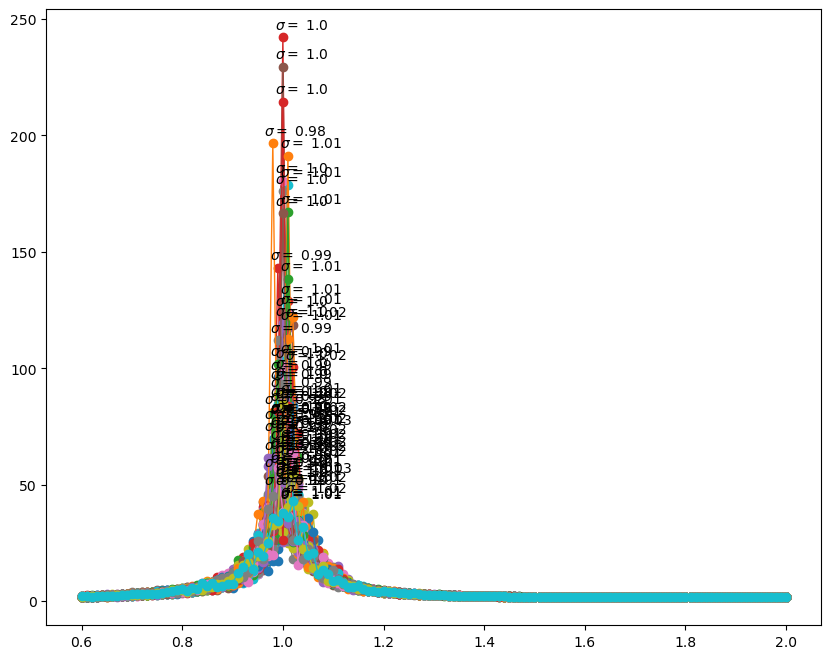

In [24]:
k = 20
trails = 100
fig, ax = plt.subplots(figsize=(10, 8))
taus = []
f0s = []
chis = []
for run in range(trails):
  timeseries = scio.loadmat(f'Aging_network/K{k}Timeseries_{run+1}.mat')
  rho = timeseries['rho']

  sigma = timeseries['sigmas'][0]
  tau = timeseries['intf'][0]
  f0 = timeseries['F0'][0]

  f0s.append(f0)
  taus.append(tau)
  # ax.plot(sigma,tau, linewidth=1, linestyle='-', marker = 'o',label = '$Run = %d$'%(run+1))
  ax.plot(sigma,tau, linewidth=1, linestyle='-', marker = 'o')
  ax.annotate(f'$\sigma = $ {sigma[np.argmax(tau)]}',
                        xy=(sigma[np.argmax(tau)], tau.max()),
                        xytext=(-6,6),  # 4 points vertical offset.
                        textcoords='offset points')
  # plt.legend()
print(sigma)

(100, 141)
(100, 141)
[ 1.70618337  1.7098668   1.71345942  1.71704351  1.72057816  1.72424984
  1.72793431  1.73170387  1.7353408   1.7390355   1.74271258  1.74647005
  1.75036698  1.75424228  1.75800265  1.76180062  1.7656802   1.76960745
  1.77353625  1.77751876  1.78149543  1.78540962  1.78956685  1.79359708
  1.79757399  1.80175184  1.80580935  1.80973608  1.81391597  1.81801884
  1.82153806  1.82406612  1.82570371  1.82765606  1.82907593  1.83071935
  1.8316703   1.8334237   1.83624425  1.83684965  1.83914335  1.84220531
  1.84724525  1.85339225  1.85929761  1.86578764  1.87394569  1.88351149
  1.89547161  1.90887945  1.92897813  1.9437565   1.96549993  1.98339454
  2.00921093  2.03186565  2.0616802   2.0879864   2.11455324  2.1427094
  2.18766738  2.21720156  2.25169712  2.29594195  2.34660001  2.39886469
  2.45190864  2.50759135  2.59121147  2.63999484  2.70483618  2.80338527
  2.90225119  3.01634131  3.10659669  3.22857789  3.36254814  3.56088478
  3.69861026  3.92872166  4.13

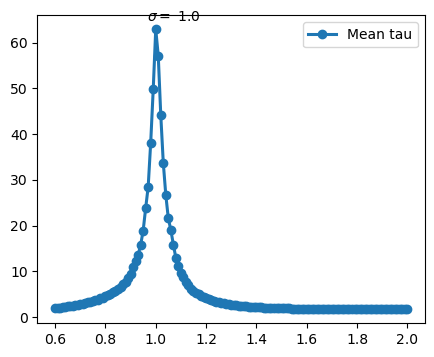

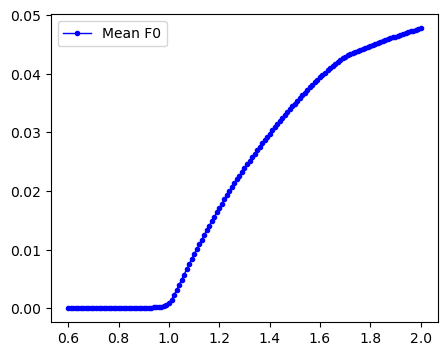

In [25]:
taus = np.array(taus)
f0s = np.array(f0s)
chis = np.array(chis)
print(taus.shape)
print(f0s.shape)
mean_taus = np.mean(taus,0)
mean_f0s = np.mean(f0s,0)
mean_chis = np.mean(chis,0)
print(mean_taus)
print(mean_f0s.shape)
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(sigma, mean_taus, linewidth= 2.2, linestyle='-', marker = 'o',label = 'Mean tau')
ax.annotate(f'$\sigma = $ {sigma[np.argmax(mean_taus)]}',
                        xy=(sigma[np.argmax(mean_taus)], mean_taus.max()),
                        xytext=(-6,6),  # 4 points vertical offset.
                        textcoords='offset points')
plt.legend()

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(sigma, mean_f0s,  linewidth = 1, linestyle='-', marker = '.', color = 'b',label = 'Mean F0')
plt.legend()

## Plotting the intrinsic timescale vs. Sigma

[1.1  1.09 1.08 1.07 1.06 1.05 1.04 1.03 1.02 1.01 1.   0.99 0.98 0.97
 0.96 0.95 0.94 0.93 0.92 0.91]
[2.   1.96 1.92 1.88 1.84 1.8  1.76 1.72 1.68 1.64 1.6  1.56 1.52 1.48
 1.44 1.4  1.36 1.32 1.28 1.24 1.2  1.16 1.12 1.1  1.09 1.08 1.07 1.06
 1.05 1.04 1.03 1.02 1.01 1.   0.99 0.98 0.97 0.96 0.95 0.94 0.93 0.92
 0.91 0.9  0.86 0.82 0.78 0.74 0.7  0.66 0.62]
[ 1.70618337  1.72057816  1.7353408   1.75036698  1.7656802   1.78149543
  1.79757399  1.81391597  1.82570371  1.8316703   1.83914335  1.85929761
  1.89547161  1.96549993  2.0616802   2.18766738  2.34660001  2.59121147
  2.90225119  3.36254814  4.13051201  5.36832869  7.66641776  9.58425869
 11.17391273 12.9224569  15.85286118 19.04094272 21.58422705 26.69851271
 33.71779602 44.16759624 57.16222126 62.92316056 49.77688553 38.14284639
 28.50315268 23.82269602 18.8945355  15.7690108  13.57096911 12.28471831
 10.89326672  9.42834829  6.6701516   5.02651162  4.06400565  3.34578587
  2.85129819  2.42684903  2.0783097 ]


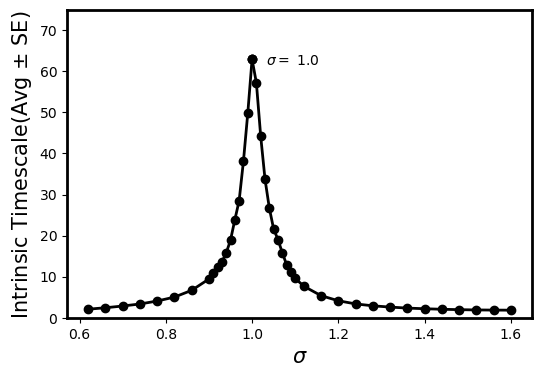

In [17]:
print(sigma[90:-31])
# print(sigma[:-31])
fig, ax = plt.subplots(figsize=(6, 4))
# s1 = np.concatenate((sigma[:-31], sigma[-31:][::3]),axis = 0)
# t1 = np.concatenate((tau[:-31],tau[-31:][::3]),axis = 0)
# print(s1)
# print(t1)
s2 = np.concatenate((sigma[:90][::4],sigma[90:-31], sigma[-31:][::4]),axis = 0)
t2 = np.concatenate((mean_taus[:90][::4],mean_taus[90:-31],mean_taus[-31:][::4]),axis = 0)
# tempp =  t2[34]
# t2[34] = t2[35]
# t2[35] = tempp
print(s2)
print(t2)

ax.plot(s2[10:34],t2[10:34], color='black', linewidth= 2.0, linestyle='-', marker = 'o')
ax.plot(s2[33:],t2[33:], color='black', linewidth= 2.0, linestyle='-', marker = 'o')
ax.plot(s2[33:34],t2[33:34], color='black', linewidth= 2.0, linestyle='-', marker = 'o')


ax.set_xlabel('$\sigma$',fontsize=15)
ax.set_ylabel('Intrinsic Timescale(Avg $\pm$ SE) ',fontsize=15)
# ax.set_title('',fontsize=15)

# ax.set_title('travel frequency vs infected ratio(N = 1000)',fontsize=32)
ax.annotate(f'$\sigma = $ {s2[np.argmax(t2)]}',
                        xy=(s2[np.argmax(t2)], t2.max()),
                        xytext=(10,-4),  # 4 points vertical offset.
                        textcoords='offset points')
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)

plt.ylim((0,75))

font_prop = font_manager.FontProperties(size=9)
# ax.legend(prop = font_prop)

bwith = 2 #边框宽度设置为2
ax = plt.gca()#获取边框
#设置边框
ax.spines['bottom'].set_linewidth(bwith)#图框下边
ax.spines['left'].set_linewidth(bwith)#图框左边

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
ax.spines['top'].set_linewidth(bwith)#图框上边
ax.spines['right'].set_linewidth(bwith)#图框右边
#取消边框
# plt.grid(color = 'black',linewidth = 1,alpha=0.4)

plt.savefig("k20_criticiaity100_6.png",bbox_inches='tight', pad_inches=0, dpi=300)

## plotting the activity transition to show the criticality 

[2.   1.96 1.92 1.88 1.84 1.8  1.76 1.72 1.68 1.64 1.6  1.56 1.52 1.48
 1.44 1.4  1.36 1.32 1.28 1.24 1.2  1.16 1.12 1.08 1.04]


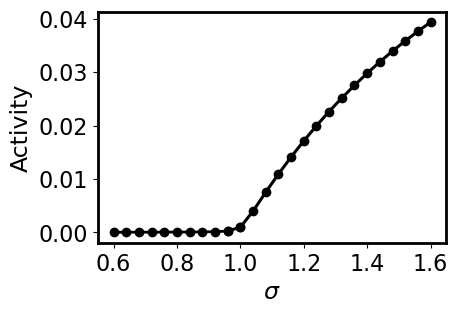

In [21]:
## F0
fig, ax = plt.subplots(figsize=(4.5, 3))
s3 = sigma[::4]
f3 = mean_f0s[::4]
nsig = np.concatenate((sigma[:20][::4],sigma[20:][::4]), axis=0)
nF0 = np.concatenate((mean_f0s[:20][::4],mean_f0s[20:][::4]), axis=0)
print(nsig[:25])
# ax.plot(nsig[10:27], nF0[10:27],  linewidth = 2.2, linestyle='-', marker = 'o', color = 'black',label = 'Supercritical')
# ax.plot(nsig[25:26], nF0[25:26],  linewidth = 2.2, linestyle='-', marker = 'o', color = 'black',label = 'Critical')
# ax.plot(nsig[26:], nF0[26:],  linewidth = 2, linestyle='-', marker = 'o', color = 'black',label = 'Subcritical')

ax.plot(nsig[10:27], nF0[10:27],  linewidth = 2.2, linestyle='-', marker = 'o', color = 'black')
ax.plot(nsig[25:26], nF0[25:26],  linewidth = 2.2, linestyle='-', marker = 'o', color = 'black')
ax.plot(nsig[26:], nF0[26:],  linewidth = 2, linestyle='-', marker = 'o', color = 'black')


ax.set_xlabel('$\sigma$',fontsize=17)
# ax.set_ylabel('Activity(Avg $\pm$ SE)',fontsize=15)
ax.set_ylabel('Activity',fontsize=17)
# ax.set_title('',fontsize=15)
# ax.set_title('travel frequency vs infected ratio(N = 1000)',fontsize=32)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
# plt.ylim((-0.005,0.048))

font_prop = font_manager.FontProperties(size=9)
# ax.legend(prop = font_prop)
bwith = 2 #边框宽度设置为2
ax = plt.gca()#获取边框
#设置边框
ax.spines['bottom'].set_linewidth(bwith)#图框下边
ax.spines['left'].set_linewidth(bwith)#图框左边

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
ax.spines['top'].set_linewidth(bwith)#图框上边
ax.spines['right'].set_linewidth(bwith)#图框右边
#取消边框
# plt.grid(color = 'black',linewidth = 1,alpha=0.4)
# plt.legend()
plt.savefig("k20_criticiaity_f0_100_5.png",bbox_inches='tight', pad_inches=0, dpi=300)

## plotting the timecourse

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

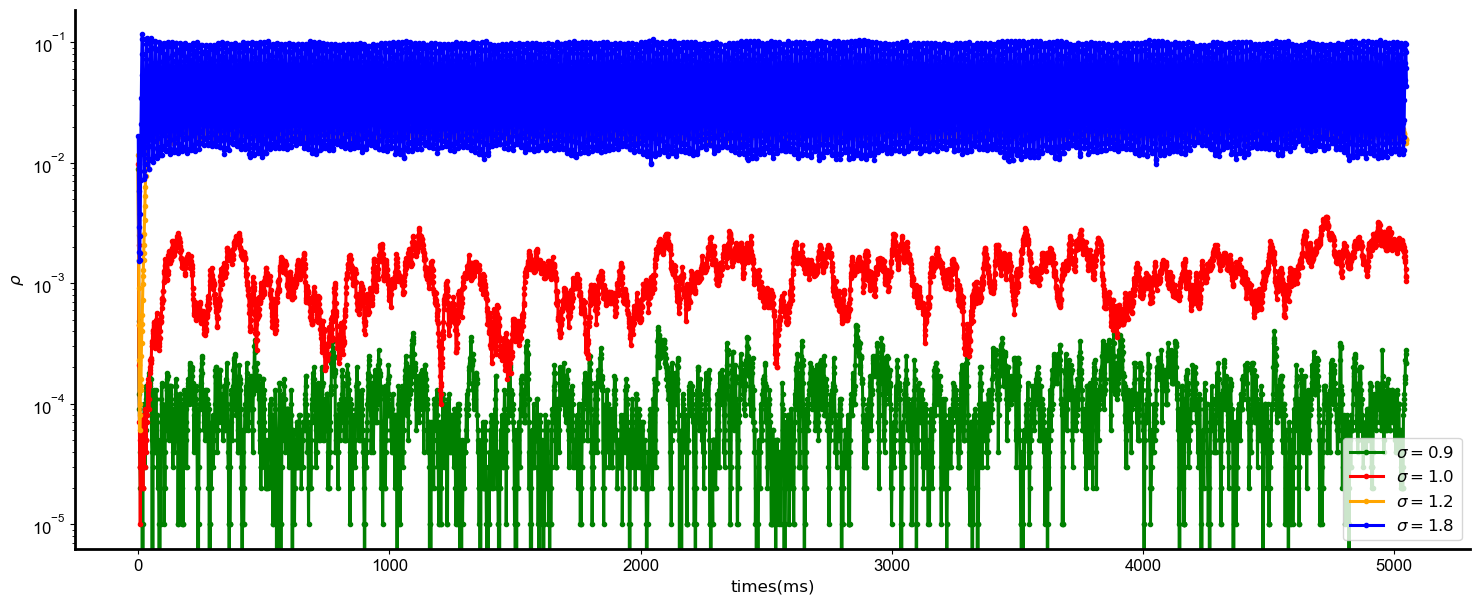

In [89]:
times = 5050
t_test = np.arange(times)

targets = [0.90, 1.0, 1.2, 1.8]
fig, ax = plt.subplots(figsize=(18, 7))
# fig, ax = plt.subplots(figsize=(4, 3))
color = ['green', 'red', 'orange', 'blue','black']
# color = ['black', 'red',  'blue',]
for n, i in enumerate(targets):
    ind = np.where(sigmas == i)[0][0]
    
    rho_t = rho[int(ind)]
    ax.plot(t_test, rho_t, marker = '.', color = color[n], linewidth = 2.2, linestyle='-',
            label = '$\sigma=%.1f$'%(i))

ax.set_xlabel('times(ms)',fontsize=12)
ax.set_ylabel('$\\rho$',fontsize= 12)
# ax.set_title('Activity test',fontsize=32)
ax.set_yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
font_prop = font_manager.FontProperties(size=12)
ax.legend(prop = font_prop)
# plt.grid()
# print('Time cost:', time.time()-start_i)
bwith = 2 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
font_prop = font_manager.FontProperties(size = 12)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Arial') for label in labels]

## Testing K = 14

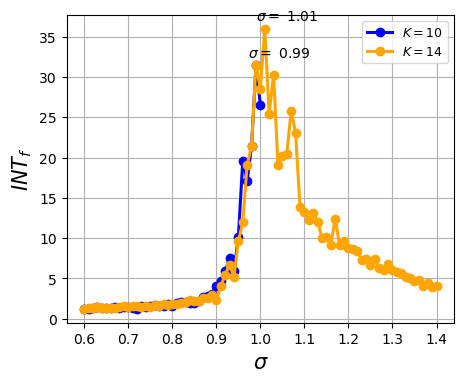

In [135]:
k = 14
timeseries = scio.loadmat(f'Aging_network/Timeseries_{k}.mat')
sigmas = timeseries['sigmas']
rho = timeseries['rho']
taus = timeseries['intf']
F0 = timeseries['F0']  

k = 14
timeseries = scio.loadmat(f'Aging_network/Timeseries_{k}.mat')
sigmas14 = timeseries['sigmas']
rho14 = timeseries['rho']
taus14 = timeseries['intf']
F014 = timeseries['F0']  

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(sigmas[0],taus[0], color='blue', linewidth=2.2, linestyle='-', marker = 'o',label = '$K = %d$'%(10))
ax.plot(sigmas14[0],taus14[0], color='orange', linewidth=2.2, linestyle='-', marker = 'o',label = '$K = %d$'%(14))

ax.annotate(f'$\sigma = $ {sigmas[0][np.argmax(taus)]}',
                        xy=(sigmas[0][np.argmax(taus)], taus.max()),
                        xytext=(-6,6),  # 4 points vertical offset.
                        textcoords='offset points')
ax.annotate(f'$\sigma = $ {sigmas14[0][np.argmax(taus14)]}',
                        xy=(sigmas14[0][np.argmax(taus14)], taus14.max()),
                        xytext=(-6,6),  # 4 points vertical offset.
                        textcoords='offset points')

ax.set_xlabel('$\sigma$',fontsize=15)
ax.set_ylabel('$INT_f$ ',fontsize=15)
# ax.set_title('travel frequency vs infected ratio(N = 1000)',fontsize=32)
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
font_prop = font_manager.FontProperties(size=9)
ax.legend(prop = font_prop)
plt.grid()

[1.2  1.19 1.18 1.17 1.16 1.15 1.14 1.13 1.12 1.11 1.1  1.09 1.08 1.07
 1.06 1.05 1.04 1.03 1.02 1.01]


[None, None, None, None, None, None, None, None, None, None, None]

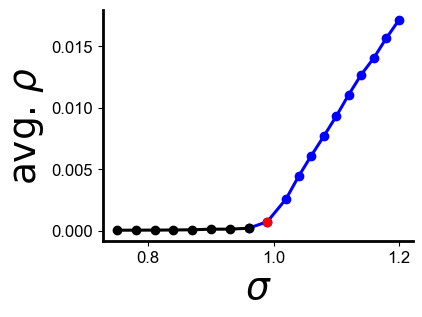

In [209]:
k = 14
fig, ax = plt.subplots(figsize=(4, 3))
while k <13:
    timeseries = scio.loadmat(f'Aging_network/Timeseries_{k}.mat')
    sigmas = timeseries['sigmas']
    rho = timeseries['rho']
    taus = timeseries['intf']
    F0 = timeseries['F0']  
    print(sigmas[0][:20])
    nsig = np.concatenate((sigmas[0][:20][::2], sigmas[0][21::3]), axis=0)
    nF0 = np.concatenate((F0[0][:20][::2], F0[0][21::3]), axis=0)
    # print(nsig)
    # ax.plot(nsig, nF0,  linewidth=2.2, linestyle='-', marker = 'o', label = '$K = %d$'%(k))
    ax.plot(nsig[:12], nF0[:12],  linewidth = 2.2, linestyle='-', marker = 'o', color = 'b')
    ax.plot(nsig[10:11], nF0[10:11],  linewidth = 2.2, linestyle='-', marker = 'o', color = 'r')
    ax.plot(nsig[11:19], nF0[11:19],  linewidth = 2.2, linestyle='-', marker = 'o', color = 'black')
    k = k+1
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('$\sigma$',fontsize=27)
ax.set_ylabel('avg. $\\rho$ ',fontsize= 27)
# ax.set_title('Transition test',fontsize=32)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
bwith = 2
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(bwith)
ax.spines['left'].set_linewidth(bwith)
font_prop = font_manager.FontProperties(size = 18)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Arial') for label in labels]
# ax.legend(prop = font_prop)
# plt.grid()

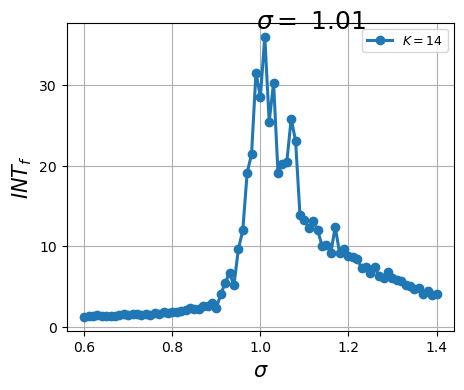

In [324]:
k = 14
fig, ax = plt.subplots(figsize=(5,4))
while k < 15:
    timeseries = scio.loadmat(f'Aging_network/Timeseries_{k}.mat')
    sigmas = timeseries['sigmas']
    rho = timeseries['rho']
    taus = timeseries['intf']
    F0 = timeseries['F0']  
    ax.plot(sigmas[0], taus[0],  linewidth=2.2, linestyle='-', marker = 'o', label = '$K = %d$'%(k))
    
    
    ax.annotate(f'$\sigma = $ {sigmas[0][np.argmax(taus)]}',
                        xy=(sigmas[0][np.argmax(taus)], taus.max()),
                        xytext=(-6,6),  # 4 points vertical offset.
                        textcoords='offset points')
    k = k+1

ax.set_xlabel('$\sigma$',fontsize=15)
ax.set_ylabel('$INT_f$ ',fontsize=15)
# ax.set_title('travel frequency vs infected ratio(N = 1000)',fontsize=32)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
font_prop = font_manager.FontProperties(size=9)
ax.legend(prop = font_prop)
plt.grid()

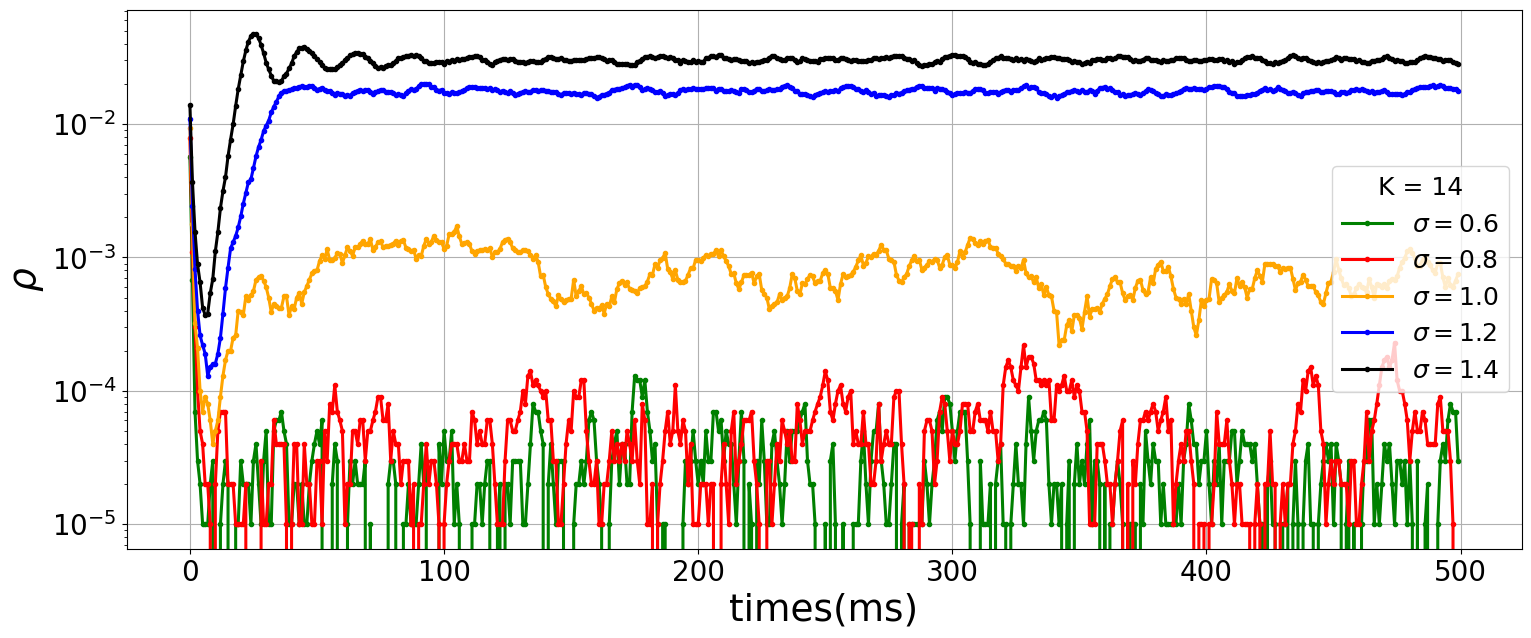

In [149]:
times = 5050
t_test = np.arange(times)

targets = [0.6, 0.8, 1.0, 1.2,1.4]
fig, ax = plt.subplots(figsize=(18, 7))
color = ['green', 'red', 'orange', 'blue','black']
for n, i in enumerate(targets):
    ind = np.where(sigmas14[0] == i)[0][0]
    
    rho_t = rho14[int(ind)]
    ax.plot(t_test[:500], rho_t[:500], marker = '.', color = color[n], linewidth = 2.2, linestyle='-',
            label = '$\sigma=%.1f$'%(i))

ax.set_xlabel('times(ms)',fontsize=27)
ax.set_ylabel('$\\rho$',fontsize=27)
# ax.set_title('Activity test',fontsize=32)
ax.set_yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# font_prop = font_manager.FontProperties(size=18)
ax.legend(prop = font_prop,title = 'K = 14')
# plt.rcParams.update({'font.size':18})

# ax.legend(title = 'K = 14', fontsize = 18)
plt.grid()
# print('Time cost:', time.time()-start_i)